In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
TEST = 'deepspeech_3'
LOG_FILE = f'results/{TEST}/log.csv'
WORKLOAD_FILE = f'results/{TEST}/workloadProfile.csv'

log_file = open(LOG_FILE, 'r')
workload_file = open(WORKLOAD_FILE, 'r')

# Read the log file into a DataFrame
metrics_df = pd.read_csv(log_file)
workload_df = pd.read_csv(workload_file, sep=';')

# Convert the timestamp to datetime
metrics_df['timestamp'] = pd.to_datetime(metrics_df['timestamp'])

# Set the timestamp as the index
metrics_df.set_index('timestamp', inplace=True)


In [10]:
unique_functions = metrics_df['function'].unique()
print(unique_functions)

['deepspeech']


In [11]:
ffmpeg_0_metrics = metrics_df[metrics_df['function'] == 'ffmpeg_0']
librosa_metrics = metrics_df[metrics_df['function'] == 'librosa']
ffmpeg_1_metrics = metrics_df[metrics_df['function'] == 'ffmpeg_1']
ffmpeg_2_metrics = metrics_df[metrics_df['function'] == 'ffmpeg_2']
deepspeech_metrics = metrics_df[metrics_df['function'] == 'deepspeech']
grep_metrics = metrics_df[metrics_df['function'] == 'grep']

In [12]:
def compute_avg_utilization(metrics_df):
    avg_util = metrics_df['utilization'].rolling(window=5, min_periods=1).mean()
    metrics_df.loc[metrics_df.index, 'avg_utilization'] = avg_util.values

In [13]:
def plot_metric(metrics_df, title):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # ax1.plot(metrics_df.index, metrics_df['theoretical_utilization'], label='Theoretical Utilization', color='tab:red')
    # ax1.plot(metrics_df.index, metrics_df['utilization'], label='Utilization', color='tab:red', linestyle=':')
    # ax1.plot(metrics_df.index, metrics_df['avg_utilization'], label='Avg utilization', color='tab:red', linestyle=':')
    ax1.set_ylabel('Utilization')
    ax1.grid(True)

    ax_seconds = ax1.twinx()
    ax_seconds.spines['left'].set_position(('outward', 60))
    ax_seconds.yaxis.set_label_position('left')
    ax_seconds.yaxis.set_ticks_position('left')
    ax_seconds.set_ylabel('Response/Service Time (seconds)')
    ax_seconds.plot(metrics_df.index, metrics_df['response_time'], label='Response Time', color='tab:cyan')
    ax_seconds.plot(metrics_df.index, metrics_df['service_time'], label='Service Time', color='tab:orange')
    ax_seconds.set_yticks(ax_seconds.get_yticks())
    ax_seconds.set_ylim(ax_seconds.get_ylim())
    # Show left ticks and labels for ax_seconds
    ax_seconds.tick_params(axis='y', left=True, labelleft=True)

    ax2 = ax1.twinx()
    ax2.plot(metrics_df.index, metrics_df['workload'], label='Measured workload', color='tab:purple', linestyle='--')
    ax2.set_ylabel('Workload')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax_seconds.get_legend_handles_labels()
    lines3, labels3 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper right')

    plt.title(f'System Metrics [{title}]')
    plt.tight_layout()
    plt.show()


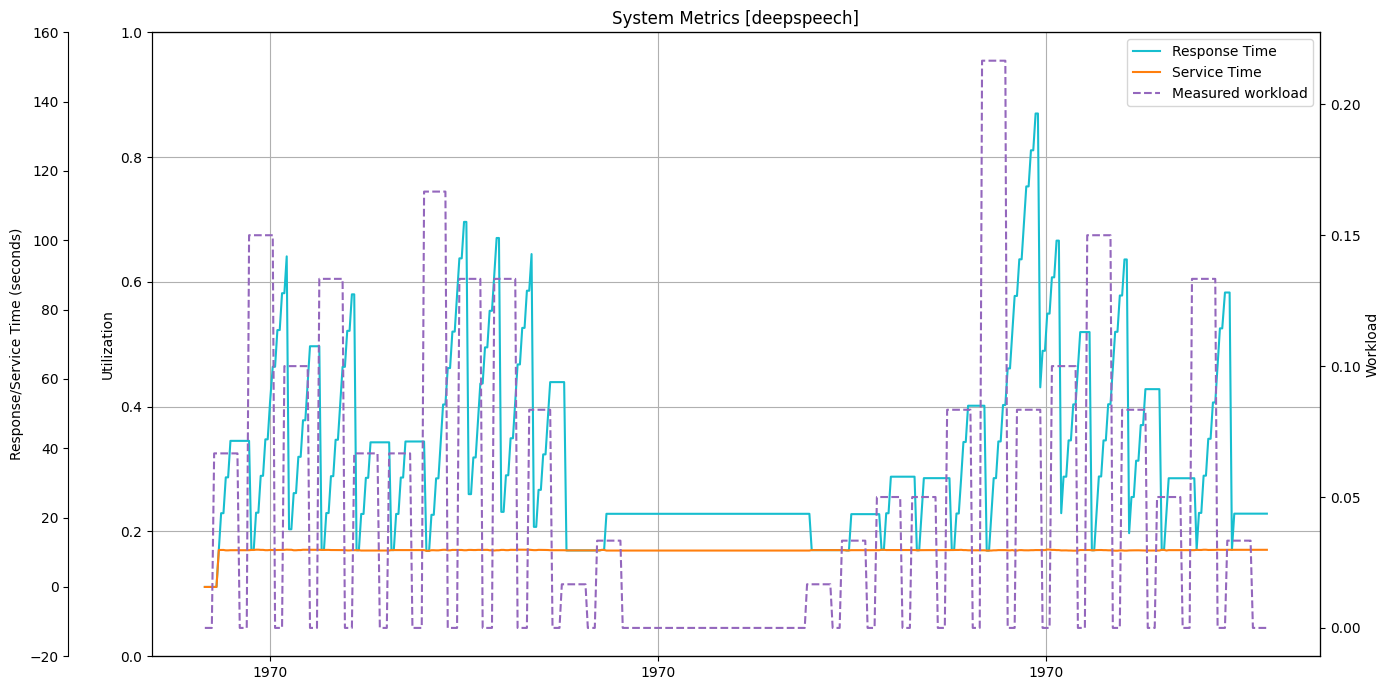

In [14]:
# compute_avg_utilization(ffmpeg_0_metrics)
# compute_avg_utilization(librosa_metrics)
# compute_avg_utilization(ffmpeg_1_metrics)
# compute_avg_utilization(ffmpeg_2_metrics)
compute_avg_utilization(deepspeech_metrics)
# compute_avg_utilization(grep_metrics)

# plot_metric(ffmpeg_0_metrics, 'ffmpeg_0')
# plot_metric(librosa_metrics, 'librosa')
# plot_metric(ffmpeg_1_metrics,  'ffmpeg_1')
# plot_metric(ffmpeg_2_metrics, 'ffmpeg_2')
plot_metric(deepspeech_metrics, 'deepspeech')
# plot_metric(grep_metrics, 'grep')

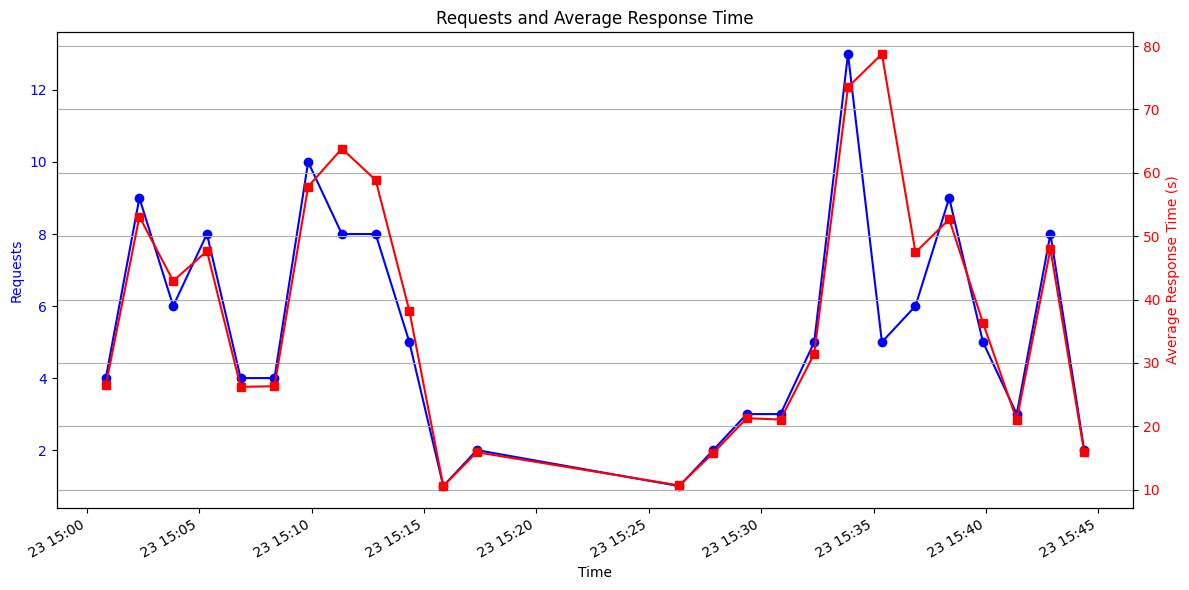

In [15]:
LOCUST_FILE = f'results/{TEST}/request_timestamps.csv'
# Load the CSV (replace 'data.csv' with your filename or use pd.read_csv with a StringIO)
locust_df = pd.read_csv(LOCUST_FILE)

# Convert timestamps to datetime
locust_df['Timestamp'] = pd.to_datetime(locust_df['Timestamp'], unit='s')
locust_df['ResponseTime'] = locust_df['ResponseTime'] / 1000  # Convert to seconds


# Sort by time
locust_df = locust_df.sort_values('Timestamp')

# Define batch threshold
batch_threshold = pd.Timedelta(seconds=10)

# Calculate time difference and batch IDs
locust_df['TimeDiff'] = locust_df['Timestamp'].diff().fillna(pd.Timedelta(seconds=0))
locust_df['BatchID'] = (locust_df['TimeDiff'] > batch_threshold).cumsum()

# Group by batch
batch_stats = locust_df.groupby('BatchID').agg(
    Timestamp=('Timestamp', 'first'),
    RequestCount=('Timestamp', 'count'),
    AvgResponseTime=('ResponseTime', 'mean')
)

# Plot with dual y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot request count
ax1.plot(batch_stats['Timestamp'], batch_stats['RequestCount'], 'b-o', label='Requests')
ax1.set_xlabel('Time')
ax1.set_ylabel('Requests', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create secondary y-axis
ax2 = ax1.twinx()
ax2.plot(batch_stats['Timestamp'], batch_stats['AvgResponseTime'], 'r-s', label='Avg Response Time')
ax2.set_ylabel('Average Response Time (s)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Final touches
plt.title('Requests and Average Response Time')
fig.autofmt_xdate()
plt.grid(True)
plt.tight_layout()
plt.show()
